# Intro

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import pyplot as plt
import copy
from netCDF4 import Dataset, num2date, date2num
import more_itertools as mit
import scipy
from scipy.interpolate import RegularGridInterpolator
from numpy import unique
from numpy import where
from matplotlib import pyplot
import matplotlib.patches as patches
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
import pandas as pd
import openpyxl
from scipy import signal
from scipy import stats
import xarray as xr
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.patches as mpatches
from scipy.stats import linregress
import sys

# Functions to compute anomalies (for 2D and 3D datasets)
def detrend_and_remove_seasonal(var):
    var_detrend = np.zeros_like(var)
    for i_box in range(73):
        temp = np.array([var[73*i_year+i_box] for i_year in range(42)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        temp = signal.detrend(temp,axis=0)
        for i_year in range(42):
            var_detrend[73*i_year+i_box]  = temp[i_year]
    return var_detrend

def remove_seasonal(var,yearN,stepN):
    var_detrend = np.zeros_like(var)
    for i_box in range(stepN):
        temp = np.array([var[stepN*i_year+i_box] for i_year in range(yearN)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        temp = signal.detrend(temp,axis=0)
        for i_year in range(yearN):
            var_detrend[stepN*i_year+i_box]  = temp[i_year]
    return var_detrend 

# Read data

In [2]:
# Load Land mask
NCname = 'land_mask.nc'
NCData = Dataset(NCname)
land_mask = np.squeeze(NCData.variables['lsm'][:])
NCData.close()

In [3]:
# Load Z500 data to extract latitude, longitude and Time arrays:
yearrange = range(1979,2021)
NCname = r'ERA5_Z500_6h_1979-2020_daymean_del29feb_1x1_5days.nc'
NCData = Dataset(NCname)
lon_era5 = NCData.variables['lon'][:]
lat_era5 = NCData.variables['lat'][:]
lon_era5 = np.append(lon_era5, 360) #Please, see comment to next to next cell
LON_era5, LAT_era5 = np.meshgrid(lon_era5, lat_era5)
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5_all = np.array([date.year for date in dates])
mon_era5_all = np.array([date.month for date in dates])
day_era5_all = np.array([date.day for date in dates])
NCData.close()

In [4]:
# Number of time step in the year:
stepN = len(year_era5_all[year_era5_all==1979])
# Number of years:
yearN = 42
#CE Region of interest:
lb_EU = 3
rb_EU = 18
bb_EU = 45
tb_EU = 55

In [5]:
# Precursors:
NCname = 'ERA5_Z500_6h_1979-2020_daymean_del29feb_1x1_5days.nc'
NCData = Dataset(NCname) 
z500 = np.array(NCData.variables['var129'][:])
z500 = z500/9.80665
z500_detrend = detrend_and_remove_seasonal(np.squeeze(z500))

# I was doing the following because otherwise there is a white strip in the middle of the plot at longitude 0 that does not get colored.
# I do not know if there is a clever way to do it, but this is how I did it back then.
pp = z500_detrend[:,:,0]
pp = pp[ :, :, np.newaxis]
z500_detrend = np.append(z500_detrend, pp, axis=2)

In [6]:
# Variables used (Temperature, Precipitation and Potential EvapoTraspiration):
t2m_region = np.array(xr.open_dataset('t2m_region.nc')['__xarray_dataarray_variable__'][:][:])
tp_region  = np.array(xr.open_dataset('tp_region.nc')['__xarray_dataarray_variable__'][:][:])
PET_region = np.array(xr.open_dataset('PET_region.nc')['__xarray_dataarray_variable__'][:][:])

# Compute anomalies:
t2m_region_de = copy.deepcopy(remove_seasonal(t2m_region,yearN,stepN))
tp_region_de  = copy.deepcopy(remove_seasonal(tp_region,yearN,stepN))
PET_region_de = copy.deepcopy(remove_seasonal(PET_region,yearN,stepN))
WSD_region_de = copy.deepcopy(remove_seasonal(tp_region*1000*24-PET_region,yearN,stepN))

# Set Temperature and Water Surplus-Deficit as the study variables for Heatwaves and Droughts:
HSI_de1 = copy.deepcopy(t2m_region_de)
SM_de1  = copy.deepcopy(WSD_region_de)
# We identify heatwaves when the temperature is above the 95th percentile (this is done only for summer): 
threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],95)
# We identify droughts when the Water Surplus-Deficit is below the 5th percentile (this is done only for summer):
threshold_SM  =  np.nanpercentile(SM_de1[np.in1d(mon_era5_all,[6,7,8])],5)
time_length = 3066

In [16]:
##To focus on first half on the analysed period
# z500_detrend = z500_detrend[0:73*21]
# mon_era5_all = mon_era5_all[0:73*21]
# HSI_de1 = HSI_de1[0:73*21]
# SM_de1  = SM_de1[0:73*21]
# threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],95)
# threshold_SM  =  np.nanpercentile(SM_de1[np.in1d(mon_era5_all,[6,7,8])],5)
# time_length = 1533

##To focus on second half on the analysed period
# z500_detrend = z500_detrend[73*21:]
# mon_era5_all = mon_era5_all[73*21:]
# HSI_de1 = HSI_de1[73*21:]
# SM_de1  = SM_de1[73*21:]
# threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],95)
# threshold_SM  =  np.nanpercentile(SM_de1[np.in1d(mon_era5_all,[6,7,8])],5)
# time_length = 1533

#  Precursor's identification for Heatwaves

In [7]:
# We identify heatwaves when the temperature is above the 95th percentile (this is done only for summer): 
HW_index = np.where(np.in1d(mon_era5_all,[6,7,8]))[0][(HSI_de1[np.in1d(mon_era5_all,[6,7,8])]>=threshold_HSI)]


In [8]:
# Use T-test to compute if the value of the precursor during the heatwaves (and also up to 2 lag before and after the
# event) is statistically different from the one during the rest of the summer (when no heatwave occurs):
p_value = []
for i_lag in [-2,-1,0,1,2]:
    p_temp = np.zeros((181,361))
    for i_i in range(181):
        for i_j in range(361):
            A = z500_detrend[:,i_i,i_j][HW_index+i_lag]
            B = z500_detrend[:,i_i,i_j][(np.in1d(mon_era5_all,[6,7,8]))&(~np.in1d(np.arange(time_length),HW_index+i_lag))]
            p_temp[i_i,i_j] = stats.ttest_ind(A,B)[1]
    p_value.append(p_temp)

# Apply False Discovery Rate correction:
q_value0 = []
for temp in p_value:
    rejected, q_temp = fdrcorrection(temp.ravel())
    q_value0.append(q_temp.reshape((181,361)))

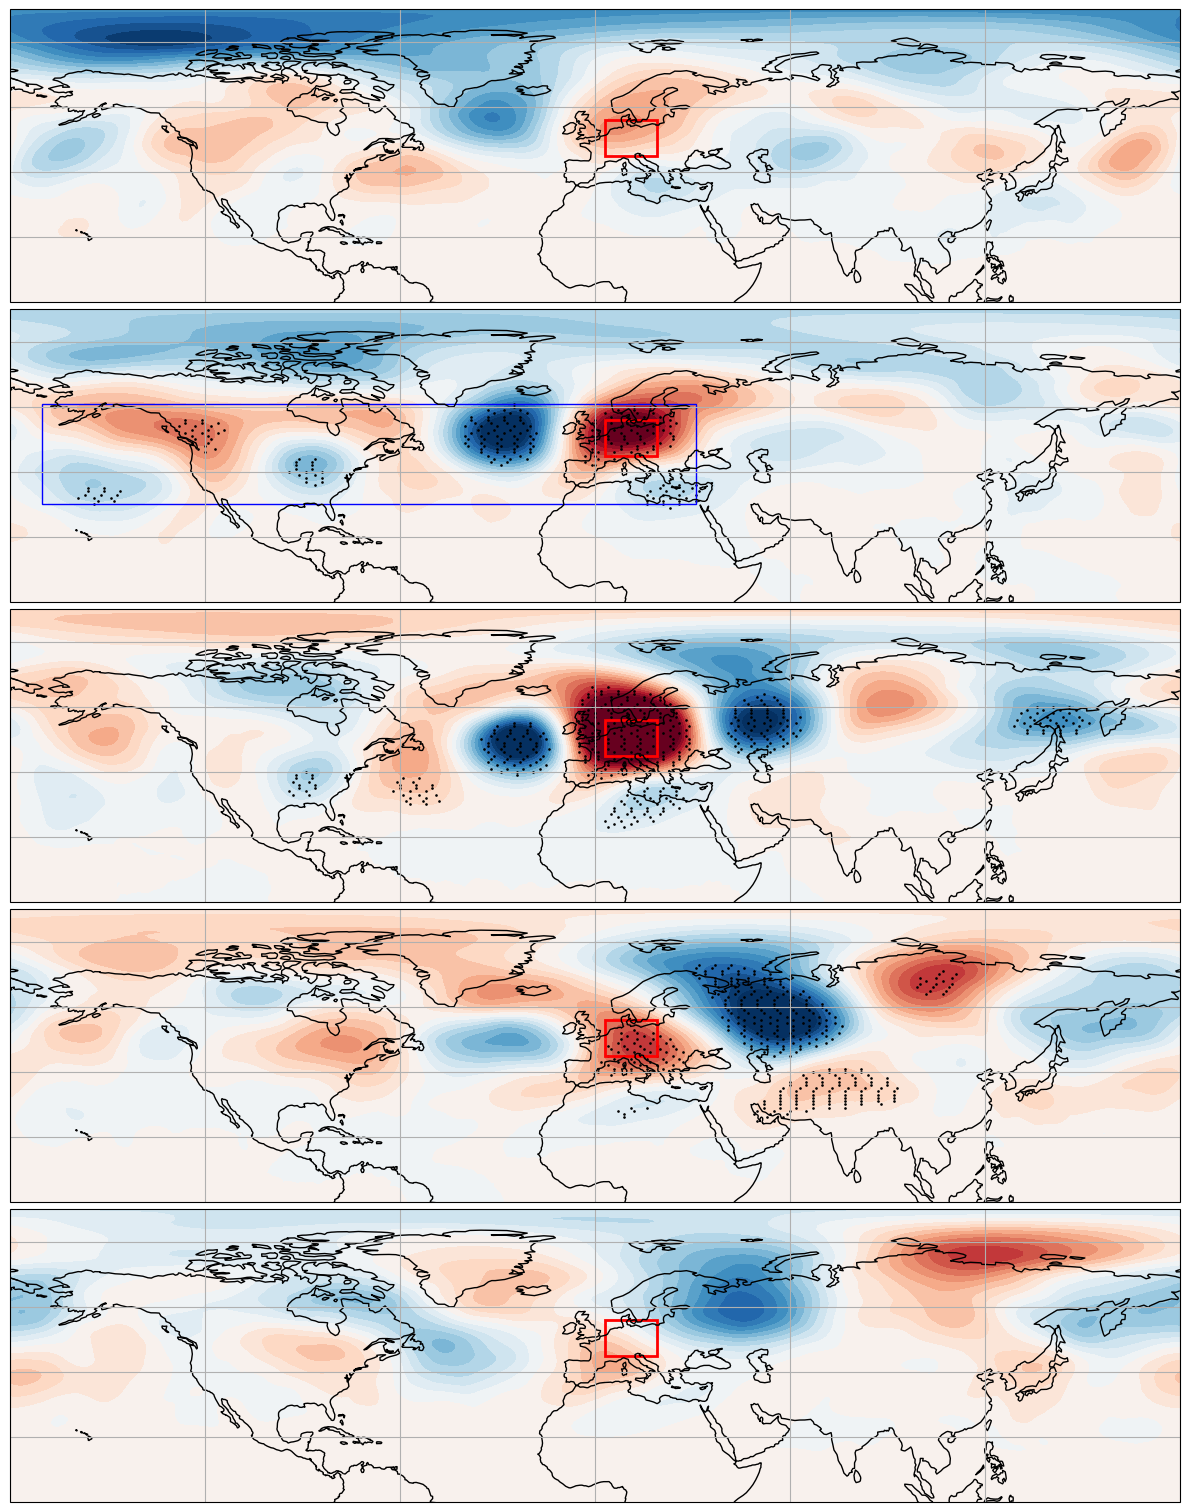

In [9]:
# We don't take the precursor in the entire globe but we select a smaller, hopefully more significant region where the
# precursor has a stronger connection to the heatwave process of the CE area under study. The selection of this region 
# is arbitrary, so we decide to try different choices to later test the sensitivity of the model to this choice. 

# 6 Waves:
bnd_n = 60
bnd_s = 30
bnd_w = -170
bnd_e = 30

# 4 Waves:
#bnd_n = 60
#bnd_s = 30
#bnd_w = -100
#bnd_e = 30

# 2 Waves:
#bnd_n = 60
#bnd_s = 30
#bnd_w = -50
#bnd_e = 30

# Plot the average precursor's value during the occurrence of heatwaves in the CE area under study, with boxes for
# the CE area under study and the precursor's region to select to enter the model: 

fig= plt.figure(figsize=(13, 15))
mpl.rc('text', usetex = False)
for i_lag in [-2,-1,0,1,2]:
    #WCE
    lon_corners = np.array([-10.,  -10., 40., 40.])
    lat_corners = np.array([ 45.,48., 61.3, 45.]) 

    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners

    poly_WCE = mpatches.Polygon(poly_corners, closed=True, ec='green', fill=False, lw=1, fc=None, transform=ccrs.PlateCarree(central_longitude=0))
    
    con_value = np.nanmean(z500_detrend[HW_index+i_lag],axis=0)
    
    proj = ccrs.PlateCarree(central_longitude=0)##
    ax = plt.axes([0.05, 1-0.05-0.2*(i_lag+2), 0.9, 0.2],projection = proj)
    #ax.text(0.02, 1.05,'Geopotential height (m) lag '+ str(i_lag),fontsize=15,transform=ax.transAxes)
    plt.contourf(LON_era5,LAT_era5,con_value,levels = np.arange(-60,65,5),cmap = 'RdBu_r',extend='both')
    #plt.colorbar()
    p_x = LON_era5[q_value0[i_lag+2]<0.05][::5]
    p_y = LAT_era5[q_value0[i_lag+2]<0.05][::5]
    plt.scatter(p_x,p_y,color='k',s=0.8)

    ax.coastlines()
    ax.gridlines()
    #if i_lag==2:
        #ax.set_xticks([ -120, -60,0, 60, 120, ], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                    number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_extent([-179, 180, 0, 90])
    #rect = patches.Rectangle((lb1, bb1), rb1-lb1+1, tb1-bb1+1, linewidth=2, edgecolor='purple', facecolor='none')
    #ax.add_patch(rect)
    rect = patches.Rectangle((lb_EU, bb_EU), rb_EU-lb_EU+1, tb_EU-bb_EU+1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    #ax.add_patch(poly_WCE)
    if i_lag==-1:
        rect = patches.Rectangle((bnd_w, bnd_s), bnd_e-bnd_w+1, bnd_n-bnd_s+1, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

pyplot.show()
plt.show()
fig.savefig(u'Fig.z500_HW_6Waves.jpg',bbox_inches = 'tight',pad_inches = 0.15, dpi=200) 

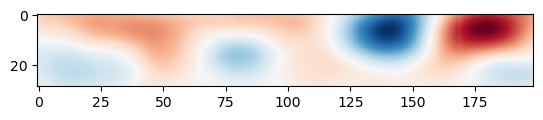

In [10]:
# Extract from the global precursor's data only the ones for the selected box and save it:

z500_new = np.concatenate((z500_detrend[:,:,180:],z500_detrend[:,:,:180]),axis=2)
lon_era5_new = np.concatenate((lon_era5[180:]-361,lon_era5[:180]),axis=0)
LON_era5_new = np.concatenate((LON_era5[:,180:]-361,LON_era5[:,:180]),axis=1)
len_lat = len(lat_era5[(lat_era5<bnd_n)&(lat_era5>bnd_s)])
len_lon = len(lon_era5[(lon_era5_new<bnd_e)&(lon_era5_new>bnd_w)])
LON_era5_box = LON_era5_new[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
LAT_era5_box = LAT_era5[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
Lag_m1 = np.nanmean(z500_new[HW_index-1],axis=0)[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))

z500_I = []
for temp in z500_new:
    temp = temp[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)]
    z500_I.append(linregress(Lag_m1.reshape(-1),temp)[2])

z500_I = np.array(z500_I)
z500_I_T =copy.deepcopy(z500_I)
z500_I_xr = xr.DataArray(z500_I,dims=['time'])
z500_I_xr.to_netcdf('z500_T2m_6Waves.nc')

plt.imshow(Lag_m1[::-1],cmap='RdBu_r')

z500_Lag1_T = copy.deepcopy(Lag_m1[::-1])
z500_Lag1_T_xr = xr.DataArray(z500_Lag1_T)
z500_Lag1_T_xr.to_netcdf('z500_T2m_6Waves_Lag1.nc')

#   Precursor's identification for Flash Droughts

In [11]:
# We identify droughts when the Water Surplus-Deficit is below the 5th percentile (this is done only for summer):
FD_index = np.where(np.in1d(mon_era5_all,[6,7,8]))[0][(SM_de1[np.in1d(mon_era5_all,[6,7,8])]<=threshold_SM)]

In [ ]:
# Use T-test to compute if the value of the precursor during the droughts (and also up to 2 lag before and after the
# event) is statistically different from the one during the rest of the summer (when no drought occurs):
p_value = []
for i_lag in [-2,-1,0,1,2]:
    p_temp = np.zeros((181,361))
    for i_i in range(181):
        for i_j in range(361):
            A = z500_detrend[:,i_i,i_j][FD_index+i_lag]
            B = z500_detrend[:,i_i,i_j][(np.in1d(mon_era5_all[:],[6,7,8]))&(~np.in1d(np.arange(time_length),FD_index+i_lag))]
            p_temp[i_i,i_j] = stats.ttest_ind(A,B)[1]
    p_value.append(p_temp)

# Apply False Discovery Rate correction:
q_value0 = []
for temp in p_value:
    rejected, q_temp = fdrcorrection(temp.ravel())
    q_value0.append(q_temp.reshape((181,361)))

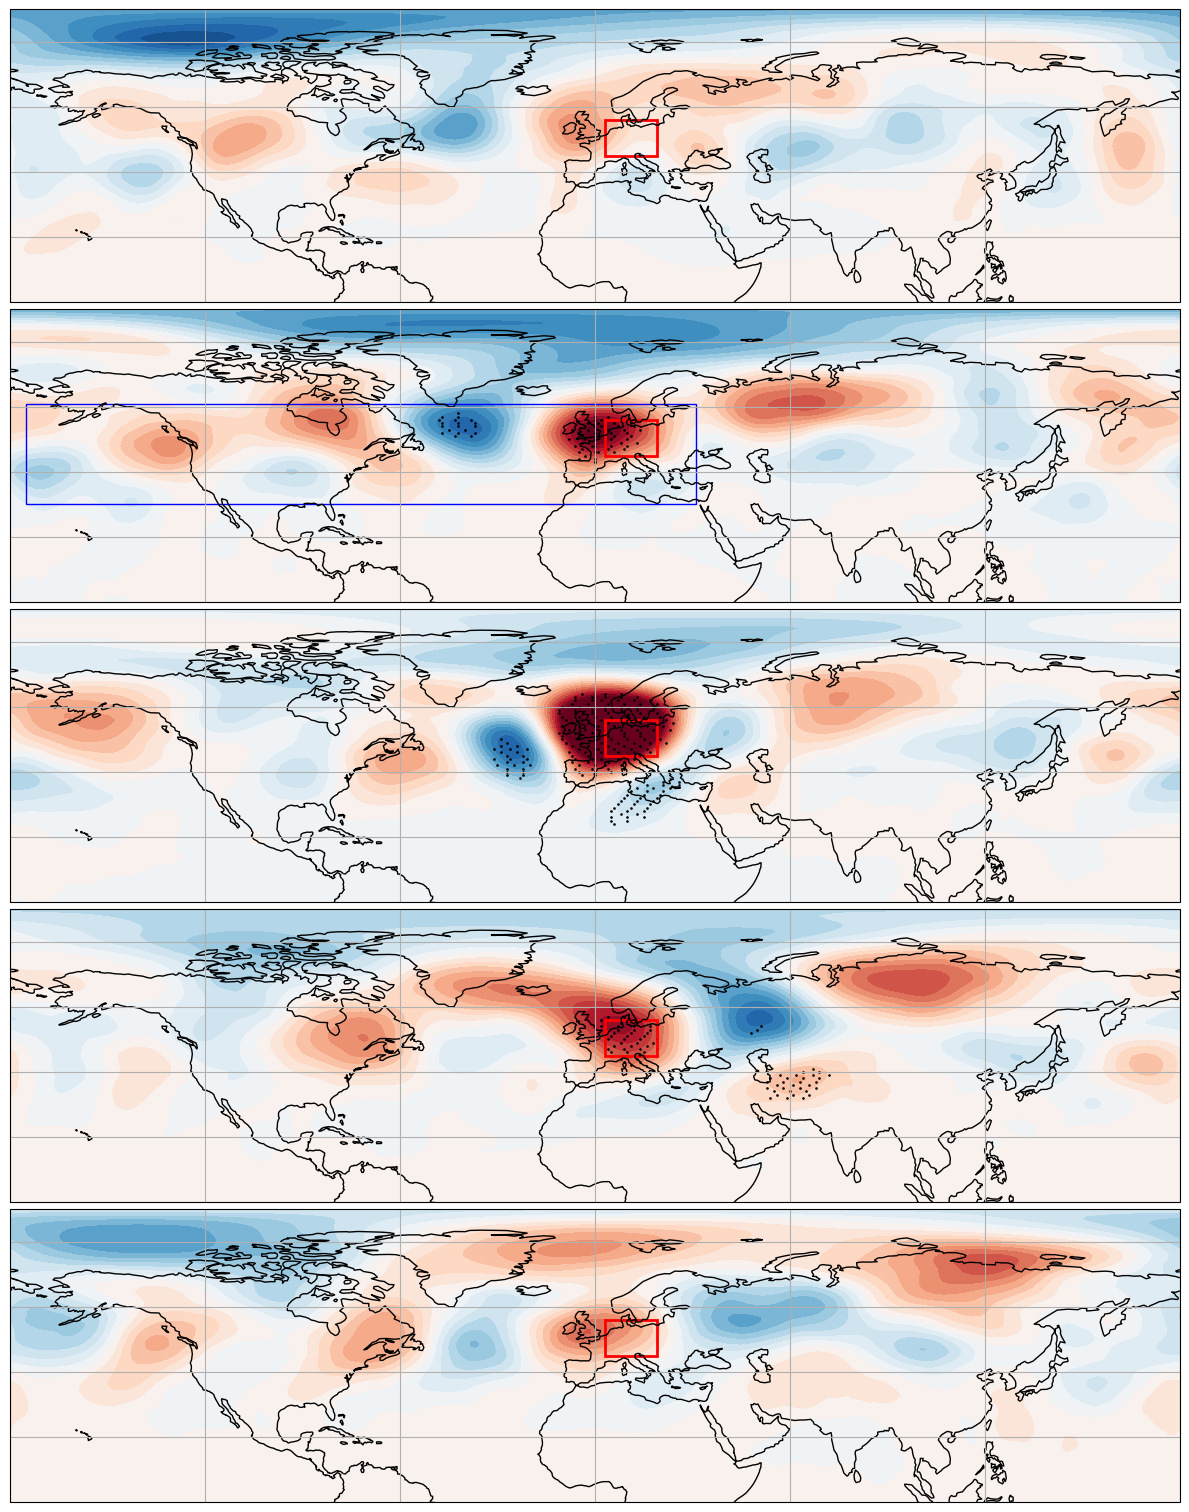

In [98]:
# We don't take the precursor in the entire globe but we select a smaller, hopefully more significant region where the
# precursor has a stronger connection to the drought process of the CE area under study. The selection of this region 
# is arbitrary, so we decide to try different choices to later test the sensitivity of the model to this choice.

# 6 Waves
bnd_n = 60
bnd_s = 30
bnd_w = -175
bnd_e = 30

# 4 Waves
#bnd_n = 60
#bnd_s = 30
#bnd_w = -110
#bnd_e = 30

# 2 Waves
#bnd_n = 60
#bnd_s = 30
#bnd_w = -60
#bnd_e = 30

# Plot the average precursor's value during the occurrence of droughts in the CE area under study, with boxes for
# the CE area under study and the precursor's region to select to enter the model: 

fig= plt.figure(figsize=(13, 15))
for i_lag in [-2,-1,0,1,2]:
    #WCE
    lon_corners = np.array([-10.,  -10., 40., 40.])
    lat_corners = np.array([ 45.,48., 61.3, 45.]) 

    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners

    poly_WCE = mpatches.Polygon(poly_corners, closed=True, ec='green', fill=False, lw=1, fc=None, transform=ccrs.PlateCarree(central_longitude=0))

    con_value = np.nanmean(z500_detrend[FD_index+i_lag],axis=0)
    
    proj = ccrs.PlateCarree(central_longitude=0)##
    ax = plt.axes([0.05, 1-0.05-0.2*(i_lag+2), 0.9, 0.2],projection = proj)
    #ax.text(0.02, 1.05,'Geopotential height (m) lag '+ str(i_lag),fontsize=15,transform=ax.transAxes)
    plt.contourf(LON_era5,LAT_era5,con_value,levels = np.arange(-60,65,5),cmap = 'RdBu_r',extend='both')
    #plt.colorbar()
    p_x = LON_era5[q_value0[i_lag+2]<0.05][::5]
    p_y = LAT_era5[q_value0[i_lag+2]<0.05][::5]
    plt.scatter(p_x,p_y,color='k',s=0.8)

    ax.coastlines()
    ax.gridlines()
    #if i_lag==2:
        #ax.set_xticks([ -120, -60,0, 60, 120, ], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                    number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_extent([-179, 180, 0, 90])
    #rect = patches.Rectangle((lb1, bb1), rb1-lb1+1, tb1-bb1+1, linewidth=2, edgecolor='purple', facecolor='none')
    #ax.add_patch(rect)
    rect = patches.Rectangle((lb_EU, bb_EU), rb_EU-lb_EU+1, tb_EU-bb_EU+1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    #ax.add_patch(poly_WCE)
    if i_lag==-1:
        rect = patches.Rectangle((bnd_w, bnd_s), bnd_e-bnd_w+1, bnd_n-bnd_s+1, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

pyplot.show()
plt.show()
fig.savefig(u'Fig.z500_FD_6Waves.jpg',bbox_inches = 'tight',pad_inches = 0.15, dpi=200) 

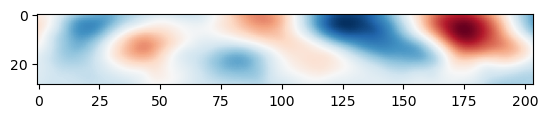

In [45]:
# Extract from the global precursor's data only the ones for the selected box and save it:

z500_new = np.concatenate((z500_detrend[:,:,180:],z500_detrend[:,:,:180]),axis=2)
lon_era5_new = np.concatenate((lon_era5[180:]-361,lon_era5[:180]),axis=0)
LON_era5_new = np.concatenate((LON_era5[:,180:]-361,LON_era5[:,:180]),axis=1)

len_lat = len(lat_era5[(lat_era5<bnd_n)&(lat_era5>bnd_s)])
len_lon = len(lon_era5[(lon_era5_new<bnd_e)&(lon_era5_new>bnd_w)])
LON_era5_box = LON_era5_new[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
LAT_era5_box = LAT_era5[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
Lag_m1 = np.nanmean(z500_new[FD_index-1],axis=0)[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))

z500_I = []
for temp in z500_new:
    temp = temp[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)]
    z500_I.append(linregress(Lag_m1.reshape(-1),temp)[2])

z500_I = np.array(z500_I)
z500_I_WSD =copy.deepcopy(z500_I)
z500_I_xr = xr.DataArray(z500_I,dims=['time'])
z500_I_xr.to_netcdf('z500_WSD_6Waves.nc')

plt.imshow(Lag_m1[::-1],cmap='RdBu_r')

z500_Lag1_WSD = copy.deepcopy(Lag_m1[::-1])
z500_Lag1_WSD_xr = xr.DataArray(z500_Lag1_WSD)
z500_Lag1_WSD_xr.to_netcdf('z500_WSD_6Waves_Lag1.nc')

# Precursor's identification for compounding Heatwaves and Flash Droughts

In [99]:
# We identify compounding Heatwaves and Flash Droughts when the Water Surplus-Deficit is below the 5th percentile 
# and the temperature is above the 95th percentile (this is done only for summer):
threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],95)
threshold_SM   =  np.nanpercentile(SM_de1[np.in1d(mon_era5_all,[6,7,8])],5)
Compound_index = np.where(np.in1d(mon_era5_all,[6,7,8]))[0][(HSI_de1[np.in1d(mon_era5_all,[6,7,8])]>=threshold_HSI)&
                                                            (SM_de1[np.in1d(mon_era5_all,[6,7,8])]<=threshold_SM)]

In [100]:
# Use T-test to compute if the value of the precursor during the compounds (and also up to 2 lag before and after the
# event) is statistically different from the one during the rest of the summer (when no compound occurs):
p_value = []
for i_lag in [-2,-1,0,1,2]:
    p_temp = np.zeros((181,361))
    for i_i in range(181):
        for i_j in range(361):
            A = z500_detrend[:,i_i,i_j][Compound_index+i_lag]
            B = z500_detrend[:,i_i,i_j][(np.in1d(mon_era5_all,[6,7,8]))&(~np.in1d(np.arange(time_length),Compound_index+i_lag))]
            p_temp[i_i,i_j] = stats.ttest_ind(A,B)[1]
    p_value.append(p_temp)

# Apply False Discovery Rate correction:
q_value0 = []
for temp in p_value:
    rejected, q_temp = fdrcorrection(temp.ravel())
    q_value0.append(q_temp.reshape((181,361)))


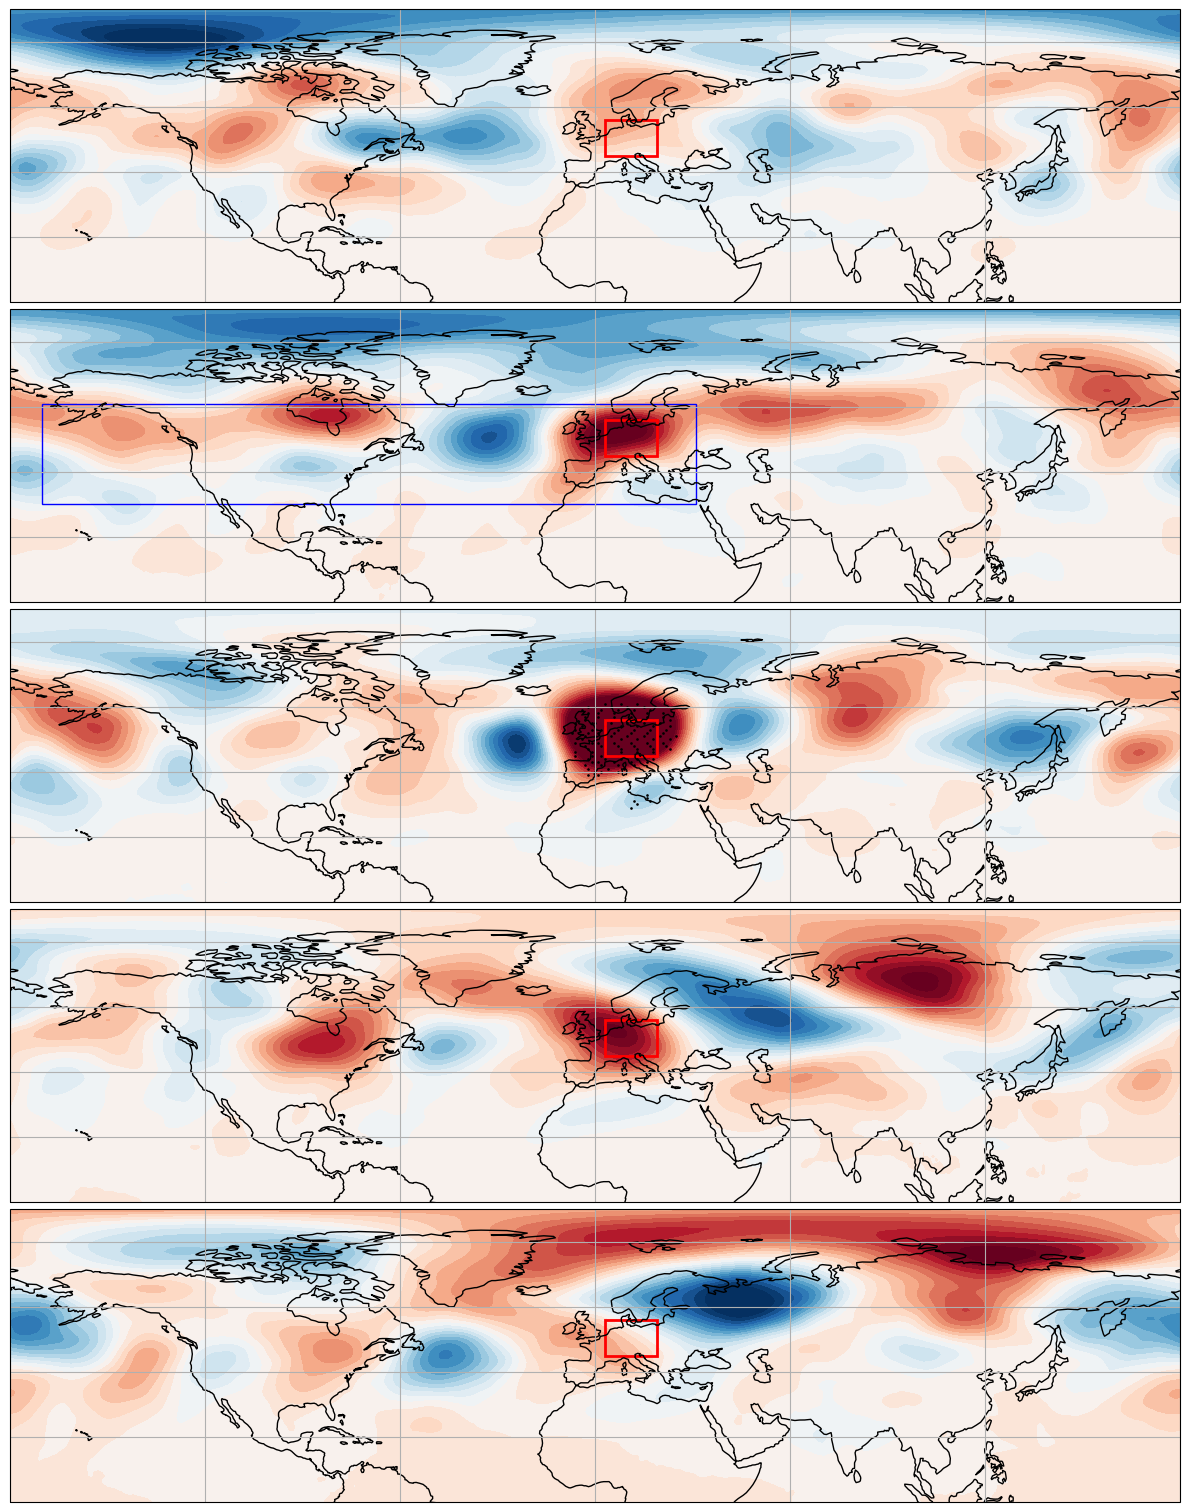

In [101]:
# We don't take the precursor in the entire globe but we select a smaller, hopefully more significant region where the
# precursor has a stronger connection to the drought process of the CE area under study. The selection of this region 
# is arbitrary, so we decide to try different choices to later test the sensitivity of the model to this choice.

# 6 Waves
bnd_n = 60
bnd_s = 30
bnd_w = -170
bnd_e = 30

# 4 Waves
#bnd_n = 60
#bnd_s = 30
#bnd_w = -110
#bnd_e = 30

# 2 Waves
#bnd_n = 60
#bnd_s = 30
#bnd_w = -50
#bnd_e = 30

# Plot the average precursor's value during the occurrence of compounds in the CE area under study, with boxes for
# the CE area under study and the precursor's region to select to enter the model: 
fig= plt.figure(figsize=(13, 15))
for i_lag in [-2,-1,0,1,2]:
    #WCE
    lon_corners = np.array([-10.,  -10., 40., 40.])
    lat_corners = np.array([ 45.,48., 61.3, 45.]) 

    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners

    poly_WCE = mpatches.Polygon(poly_corners, closed=True, ec='green', fill=False, lw=1, fc=None, transform=ccrs.PlateCarree(central_longitude=0))

    con_value = np.nanmean(z500_detrend[Compound_index+i_lag],axis=0)
    
    proj = ccrs.PlateCarree(central_longitude=0)##
    ax = plt.axes([0.05, 1-0.05-0.2*(i_lag+2), 0.9, 0.2],projection = proj)
    #ax.text(0.02, 1.05,'Geopotential height (m) lag '+ str(i_lag),fontsize=15,transform=ax.transAxes)
    plt.contourf(LON_era5,LAT_era5,con_value,levels = np.arange(-60,65,5),cmap = 'RdBu_r',extend='both')
    #plt.colorbar()
    p_x = LON_era5[q_value0[i_lag+2]<0.05][::5]
    p_y = LAT_era5[q_value0[i_lag+2]<0.05][::5]
    plt.scatter(p_x,p_y,color='k',s=0.8)

    ax.coastlines()
    ax.gridlines()
    #if i_lag==2:
        #ax.set_xticks([ -120, -60,0, 60, 120, ], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                    number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_extent([-179, 180, 0, 90])
    #rect = patches.Rectangle((lb1, bb1), rb1-lb1+1, tb1-bb1+1, linewidth=2, edgecolor='purple', facecolor='none')
    #ax.add_patch(rect)
    rect = patches.Rectangle((lb_EU, bb_EU), rb_EU-lb_EU+1, tb_EU-bb_EU+1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    #ax.add_patch(poly_WCE)
    if i_lag==-1:
        rect = patches.Rectangle((bnd_w, bnd_s), bnd_e-bnd_w+1, bnd_n-bnd_s+1, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

pyplot.show()
plt.show()
fig.savefig(u'Fig.z500_compound_6Waves.jpg',bbox_inches = 'tight',pad_inches = 0.15, dpi=200) 

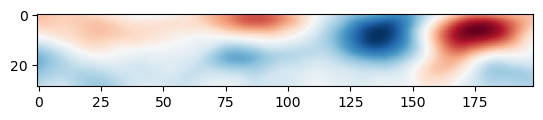

In [12]:
z500_new = np.concatenate((z500_detrend[:,:,180:],z500_detrend[:,:,:180]),axis=2)
lon_era5_new = np.concatenate((lon_era5[180:]-361,lon_era5[:180]),axis=0)
LON_era5_new = np.concatenate((LON_era5[:,180:]-361,LON_era5[:,:180]),axis=1)

len_lat = len(lat_era5[(lat_era5<bnd_n)&(lat_era5>bnd_s)])
len_lon = len(lon_era5[(lon_era5_new<bnd_e)&(lon_era5_new>bnd_w)])
LON_era5_box = LON_era5_new[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
LAT_era5_box = LAT_era5[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
Lag_m1 = np.nanmean(z500_new[Compound_index-1],axis=0)[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))

z500_I = []
for temp in z500_new:
    temp = temp[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)]
    z500_I.append(linregress(Lag_m1.reshape(-1),temp)[2])
    
z500_I = np.array(z500_I)
z500_I_xr = xr.DataArray(z500_I,dims=['time'])
z500_I_xr.to_netcdf('z500_compound_6Waves.nc')

plt.imshow(Lag_m1[::-1],cmap='RdBu_r')

z500_Lag1_C = copy.deepcopy(Lag_m1[::-1])
z500_Lag1_C_xr = xr.DataArray(z500_Lag1_C)
z500_Lag1_C_xr.to_netcdf('z500_compound_6Waves_Lag1.nc')


# Independent T

In [20]:
threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],95)
threshold_SM  =  np.nanpercentile(SM_de1[np.in1d(mon_era5_all,[6,7,8])],5)
Independent_index = np.where(np.in1d(mon_era5_all,[6,7,8]))[0][(HSI_de1[np.in1d(mon_era5_all,[6,7,8])]>=threshold_HSI)&(SM_de1[np.in1d(mon_era5_all,[6,7,8])]>threshold_SM)]

In [21]:
p_value = []
for i_lag in [-2,-1,0,1,2]:
    p_temp = np.zeros((181,361))
    for i_i in range(181):
        for i_j in range(361):
            A = z500_detrend[:,i_i,i_j][Independent_index+i_lag]
            B = z500_detrend[:,i_i,i_j][(np.in1d(mon_era5_all,[6,7,8]))&(~np.in1d(np.arange(time_length),Independent_index+i_lag))]
            p_temp[i_i,i_j] = stats.ttest_ind(A,B)[1]
    p_value.append(p_temp)
q_value1 = []
for temp in p_value:
    rejected, q_temp = fdrcorrection(temp.ravel())
    q_value1.append(q_temp.reshape((181,361)))

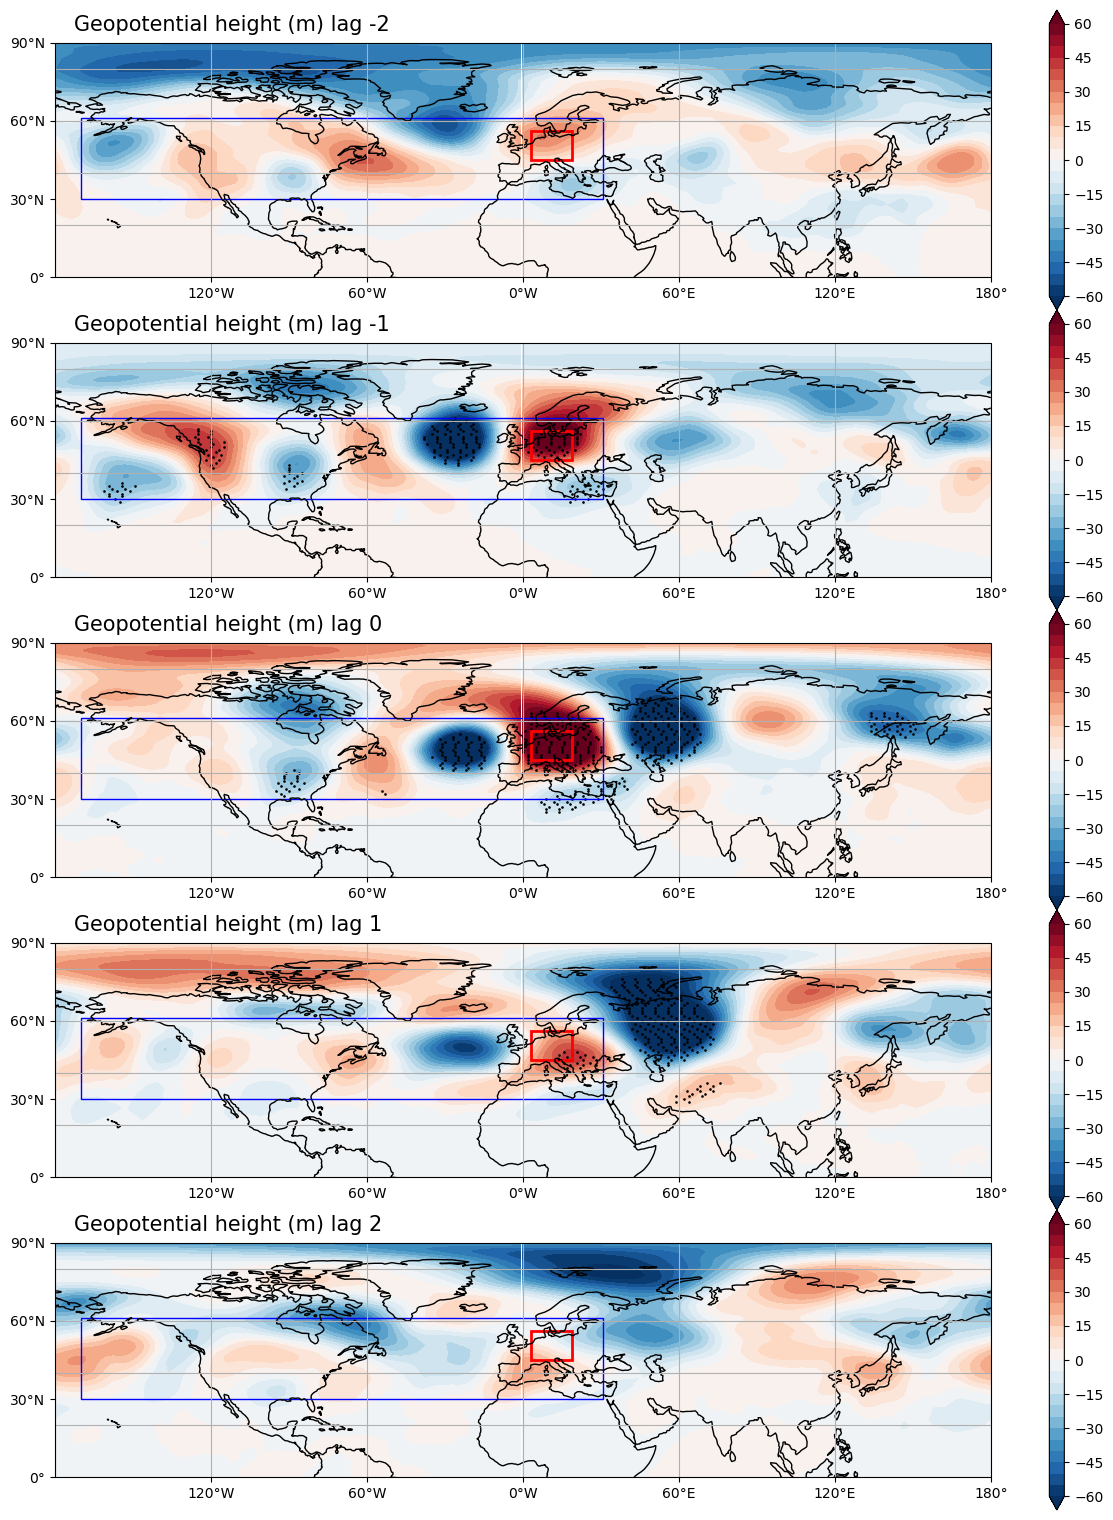

In [23]:
# 6 Waves:
bnd_n = 60
bnd_s = 30
bnd_w = -170
bnd_e = 30

# 4 Waves:
#bnd_n = 60
#bnd_s = 30
#bnd_w = -100
#bnd_e = 30

# 2 Waves:
#bnd_n = 60
#bnd_s = 30
#bnd_w = -45
#bnd_e = 30

fig= plt.figure(figsize=(13, 15))

for i_lag in [-2,-1,0,1,2]:
    #WCE
    lon_corners = np.array([-10.,  -10., 40., 40.])
    lat_corners = np.array([ 45.,48., 61.3, 45.]) 

    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners

    poly_WCE = mpatches.Polygon(poly_corners, closed=True, ec='green', fill=False, lw=1, fc=None, transform=ccrs.PlateCarree(central_longitude=0))

    con_value = np.nanmean(z500_detrend[Independent_index+i_lag],axis=0)
    
    proj = ccrs.PlateCarree(central_longitude=0)##
    ax = plt.axes([0.05, 1-0.05-0.2*(i_lag+2), 0.9, 0.2],projection = proj)
    ax.text(0.02, 1.05,'Geopotential height (m) lag '+ str(i_lag),fontsize=15,transform=ax.transAxes)
    plt.contourf(LON_era5,LAT_era5,con_value,levels = np.arange(-60,65,5),cmap = 'RdBu_r',extend='both')
    plt.colorbar()
    p_x = LON_era5[q_value1[i_lag+2]<0.05][::5]
    p_y = LAT_era5[q_value1[i_lag+2]<0.05][::5]
    plt.scatter(p_x,p_y,color='k',s=0.8)

    ax.coastlines()
    ax.gridlines()
    ax.set_xticks([-180, -120, -60,0, 60, 120, 180, ], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                    number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_extent([-179, 180, 0, 90])
    #rect = patches.Rectangle((lb1, bb1), rb1-lb1+1, tb1-bb1+1, linewidth=2, edgecolor='purple', facecolor='none')
    #ax.add_patch(rect)
    rect = patches.Rectangle((lb_EU, bb_EU), rb_EU-lb_EU+1, tb_EU-bb_EU+1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    #ax.add_patch(poly_WCE)
    rect = patches.Rectangle((bnd_w, bnd_s), bnd_e-bnd_w+1, bnd_n-bnd_s+1, linewidth=1, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)

pyplot.show()
plt.show()
fig.savefig(u'Fig.z500_independent_T_6Waves.jpg',bbox_inches = 'tight',pad_inches = 0.15, dpi=200) 

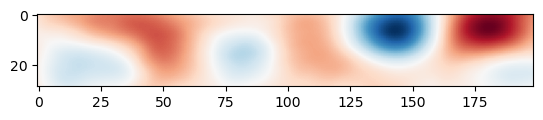

In [24]:
z500_new = np.concatenate((z500_detrend[:,:,180:],z500_detrend[:,:,:180]),axis=2)
lon_era5_new = np.concatenate((lon_era5[180:]-361,lon_era5[:180]),axis=0)
LON_era5_new = np.concatenate((LON_era5[:,180:]-361,LON_era5[:,:180]),axis=1)

len_lat = len(lat_era5[(lat_era5<bnd_n)&(lat_era5>bnd_s)])
len_lon = len(lon_era5[(lon_era5_new<bnd_e)&(lon_era5_new>bnd_w)])
LON_era5_box = LON_era5_new[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
LAT_era5_box = LAT_era5[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
Lag_m1 = np.nanmean(z500_new[Independent_index-1],axis=0)[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))

z500_I = []
for temp in z500_new:
    temp = temp[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)]
    z500_I.append(linregress(Lag_m1.reshape(-1),temp)[2])
    
z500_I = np.array(z500_I)
z500_I_xr = xr.DataArray(z500_I,dims=['time'])
z500_I_xr.to_netcdf('z500_Independent_T_6Waves.nc')

plt.imshow(Lag_m1[::-1],cmap='RdBu_r')

# independent WSD

In [25]:
threshold_HSI  =  np.nanpercentile(HSI_de1[np.in1d(mon_era5_all,[6,7,8])],95)
threshold_SM  =  np.nanpercentile(SM_de1[np.in1d(mon_era5_all,[6,7,8])],5)
Independent_index = np.where(np.in1d(mon_era5_all,[6,7,8]))[0][(HSI_de1[np.in1d(mon_era5_all,[6,7,8])]<threshold_HSI)&(SM_de1[np.in1d(mon_era5_all,[6,7,8])]<=threshold_SM)]

In [26]:
p_value = []
for i_lag in [-2,-1,0,1,2]:
    p_temp = np.zeros((181,361))
    for i_i in range(181):
        for i_j in range(361):
            A = z500_detrend[:,i_i,i_j][Independent_index+i_lag]
            B = z500_detrend[:,i_i,i_j][(np.in1d(mon_era5_all,[6,7,8]))&(~np.in1d(np.arange(time_length),Independent_index+i_lag))]
            p_temp[i_i,i_j] = stats.ttest_ind(A,B)[1]
    p_value.append(p_temp)
q_value2 = []
for temp in p_value:
    rejected, q_temp = fdrcorrection(temp.ravel())
    q_value2.append(q_temp.reshape((181,361)))

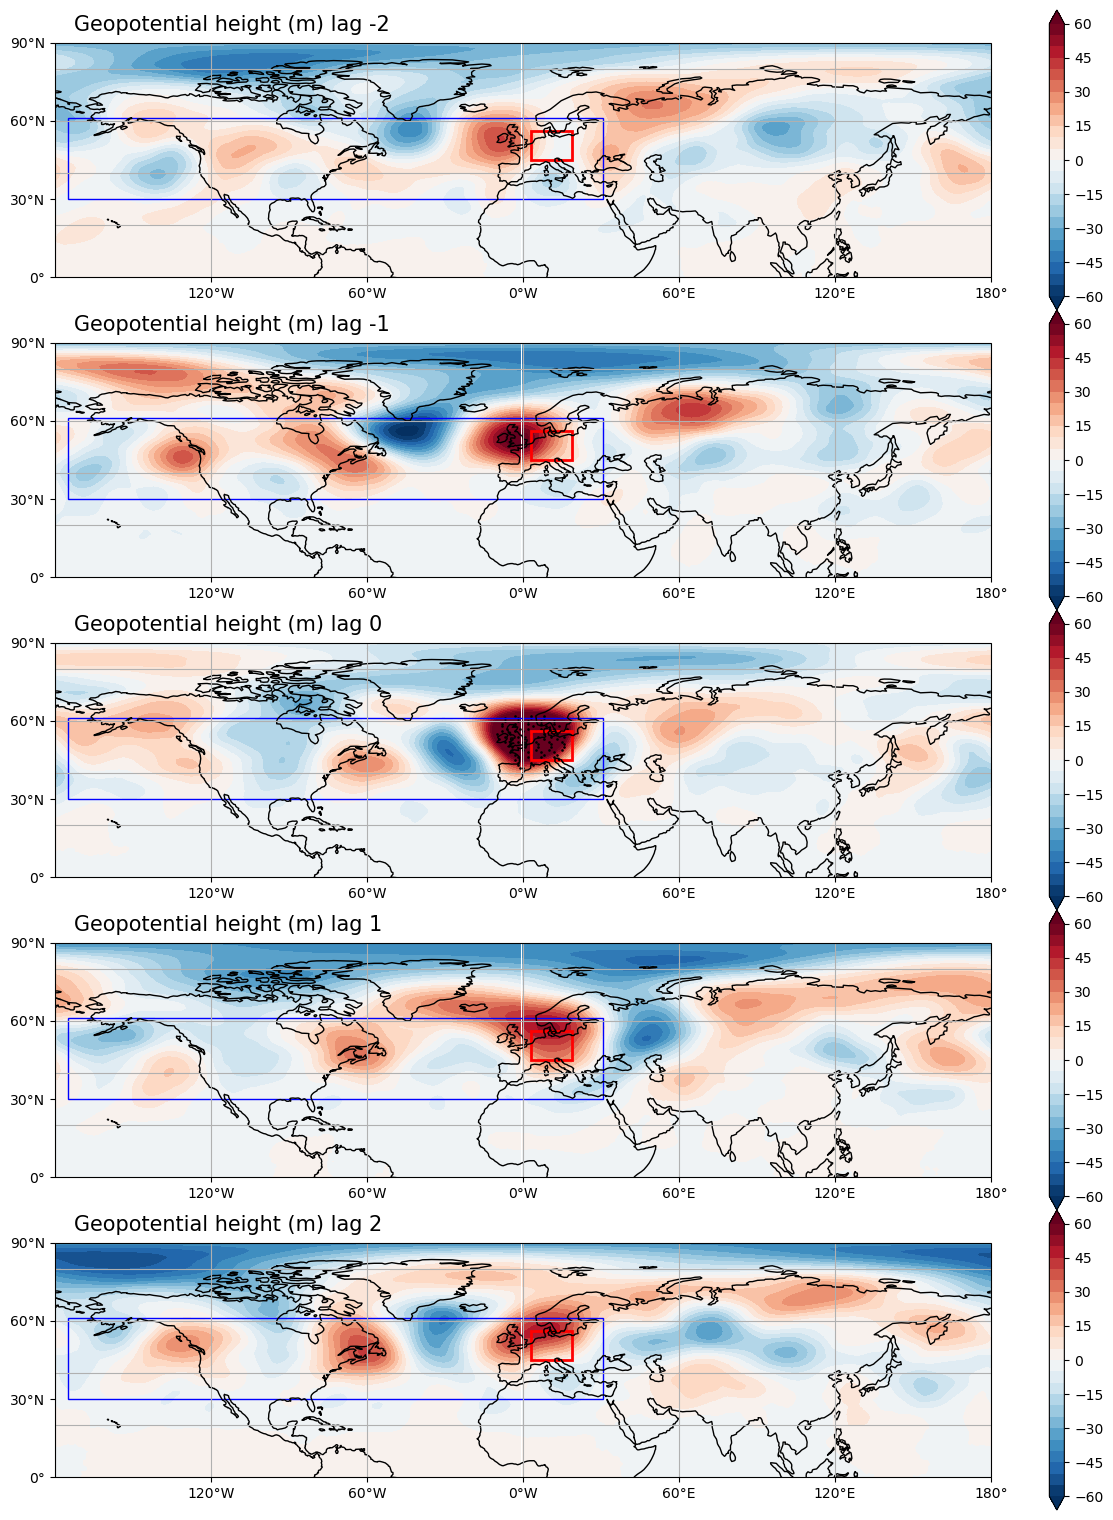

In [27]:
# 6 Waves
bnd_n = 60
bnd_s = 30
bnd_w = -175
bnd_e = 30

# 4 Waves
#bnd_n = 60
#bnd_s = 30
#bnd_w = -110
#bnd_e = 30

# 2 Waves
#bnd_n = 60
#bnd_s = 30
#bnd_w = -55
#bnd_e = 30

fig= plt.figure(figsize=(13, 15))
for i_lag in [-2,-1,0,1,2]:
    #WCE
    lon_corners = np.array([-10.,  -10., 40., 40.])
    lat_corners = np.array([ 45.,48., 61.3, 45.]) 

    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners

    poly_WCE = mpatches.Polygon(poly_corners, closed=True, ec='green', fill=False, lw=1, fc=None, transform=ccrs.PlateCarree(central_longitude=0))

    con_value = np.nanmean(z500_detrend[Independent_index+i_lag],axis=0)
    
    proj = ccrs.PlateCarree(central_longitude=0)##
    ax = plt.axes([0.05, 1-0.05-0.2*(i_lag+2), 0.9, 0.2],projection = proj)
    ax.text(0.02, 1.05,'Geopotential height (m) lag '+ str(i_lag),fontsize=15,transform=ax.transAxes)
    plt.contourf(LON_era5,LAT_era5,con_value,levels = np.arange(-60,65,5),cmap = 'RdBu_r',extend='both')
    plt.colorbar()
    
    p_x = LON_era5[q_value2[i_lag+2]<0.05][::5]
    p_y = LAT_era5[q_value2[i_lag+2]<0.05][::5]
    plt.scatter(p_x,p_y,color='k',s=0.8)

    ax.coastlines()
    ax.gridlines()
    ax.set_xticks([-180, -120, -60,0, 60, 120, 180, ], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                    number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_extent([-179, 180, 0, 90])
    #rect = patches.Rectangle((lb1, bb1), rb1-lb1+1, tb1-bb1+1, linewidth=2, edgecolor='purple', facecolor='none')
    #ax.add_patch(rect)
    rect = patches.Rectangle((lb_EU, bb_EU), rb_EU-lb_EU+1, tb_EU-bb_EU+1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    #ax.add_patch(poly_WCE)
    rect = patches.Rectangle((bnd_w, bnd_s), bnd_e-bnd_w+1, bnd_n-bnd_s+1, linewidth=1, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)

pyplot.show()
plt.show()

fig.savefig(u'Fig.z500_Independent_WSD_6Waves.jpg',bbox_inches = 'tight',pad_inches = 0.15, dpi=200) 

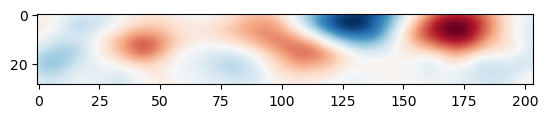

In [28]:
z500_new = np.concatenate((z500_detrend[:,:,180:],z500_detrend[:,:,:180]),axis=2)
lon_era5_new = np.concatenate((lon_era5[180:]-361,lon_era5[:180]),axis=0)
LON_era5_new = np.concatenate((LON_era5[:,180:]-361,LON_era5[:,:180]),axis=1)

len_lat = len(lat_era5[(lat_era5<bnd_n)&(lat_era5>bnd_s)])
len_lon = len(lon_era5[(lon_era5_new<bnd_e)&(lon_era5_new>bnd_w)])
LON_era5_box = LON_era5_new[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
LAT_era5_box = LAT_era5[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))
Lag_m1 = np.nanmean(z500_new[Independent_index-1],axis=0)[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)].reshape((len_lat ,len_lon))

z500_I = []
for temp in z500_new:
    temp = temp[(LON_era5_new<bnd_e)&(LON_era5_new>bnd_w)&(LAT_era5<bnd_n)&(LAT_era5>bnd_s)]
    z500_I.append(linregress(Lag_m1.reshape(-1),temp)[2])
z500_I = np.array(z500_I)
z500_I_xr = xr.DataArray(z500_I,dims=['time'])
z500_I_xr.to_netcdf('z500_Independent_WSD_6Waves.nc')

plt.imshow(Lag_m1[::-1],cmap='RdBu_r')